In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dane = "/DATA/shared/datasets/cifar10/cifar10_test.tfrecord"
dane_train = "/DATA/shared/datasets/cifar10/cifar10_train.tfrecord"

In [7]:
def read_data(filename_queue):
    reader = tf.TFRecordReader()
    _, se = reader.read(filename_queue)
    f = tf.parse_single_example(se,features={'image/encoded':tf.FixedLenFeature([],tf.string),
                                            'image/class/label':tf.FixedLenFeature([],tf.int64),
                                            'image/height':tf.FixedLenFeature([],tf.int64),
                                            'image/width':tf.FixedLenFeature([],tf.int64)})
    image = tf.image.decode_png(f['image/encoded'],channels=3)
    image.set_shape( (32,32,3) ) 
    return image,f['image/class/label']

In [8]:
from IPython.display import clear_output

In [34]:
tf.reset_default_graph()

In [35]:
fq = tf.train.string_input_producer([dane_train])
image_data, label = read_data(filename_queue=fq)

Przygotowanie zbiorów treningowego oraz testowego 
Obrazki zbioru treningowego ulegają łosowej transformacji (łosowe przewracanie w prawą lub lewą stronę o 90 stopni)

In [36]:
batch_size = 128
images, sparse_labels = tf.train.shuffle_batch([tf.image.random_flip_left_right(image_data),label],batch_size=batch_size,
                                               num_threads=2,
                                               capacity=1000+3*batch_size,
                                               min_after_dequeue=1000
                                               )
images = (tf.cast(images,tf.float32)-128.0)/33.0
fq_test = tf.train.string_input_producer([dane])
test_image_data, test_label = read_data(filename_queue=fq_test)
test_images, test_sparse_labels = tf.train.batch( [test_image_data,test_label],batch_size=batch_size,
                                               num_threads=2,
                                               capacity=1000+3*batch_size,
                                               )
test_images = (tf.cast(test_images,tf.float32)-128.0)/33.0

Definiujemy sieć konwolucyjną

In [55]:
tf.set_random_seed=1
net = tf.contrib.layers.conv2d( images, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.conv2d( net, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.conv2d( net, 32, 3, padding='VALID')
net = tf.contrib.layers.max_pool2d( net, 2, 2, padding='VALID')

net = tf.contrib.layers.fully_connected(tf.reshape(net,[-1,2*2*32]), 32)
net = tf.contrib.layers.fully_connected(net, 10, activation_fn=None)
logits = net

xent = tf.losses.sparse_softmax_cross_entropy(sparse_labels,net)
loss = tf.reduce_mean( xent)



W dalszej części notatnika sprawdzane są dokładności treningowe i testowe trzech optymalizatorów: Adam , Adagrad i Adadel. Wyświetlane są wykresy dynamiki treningowej, oraz wartości wy=uncji losu na zbiorze treningowym

In [ ]:
opt = tf.train.AdamOptimizer(0.0001) 
train_op = opt.minimize(loss)

In [26]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

In [59]:
global_step = 0

In [28]:

lvals = []


for i in range(global_step,global_step+15000):
    l, _ = sess.run([loss,train_op])
    if i%10==0:   
        clear_output(wait=True)
        print(l,i+1)
    if i%100==0:
        Images,Labels = sess.run([test_images,test_sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r_test = np.sum(predicted==Labels)/Labels.size
        
        Images,Labels = sess.run([images,sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r = np.sum(predicted==Labels)/Labels.size
        lvals.append([i,l,r,r_test])

global_step = i+1

1.14733 14991


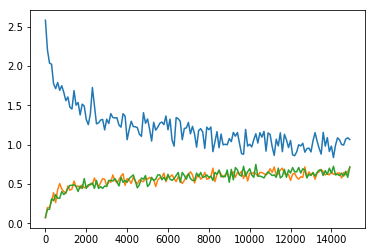

In [29]:
lvals = np.array(lvals) #ziel.-trening. pomar.-test. nieb.-entr
plt.plot(lvals[:,0],lvals[:,1])

plt.plot(lvals[:,0],lvals[:,3])
plt.plot(lvals[:,0],lvals[:,2])

In [56]:
opt = tf.train.AdagradOptimizer(0.01) 
train_op = opt.minimize(loss)

In [57]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

In [60]:
%time 
lals = []


for i in range(global_step,global_step+15000):
    l, _ = sess.run([loss,train_op])
    if i%10==0:   
        clear_output(wait=True)
        print(l,i+1)
    if i%100==0:
        Images,Labels = sess.run([test_images,test_sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r_test = np.sum(predicted==Labels)/Labels.size
        
        Images,Labels = sess.run([images,sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r = np.sum(predicted==Labels)/Labels.size
        lals.append([i,l,r,r_test])

global_step = i+1

0.854855 14991


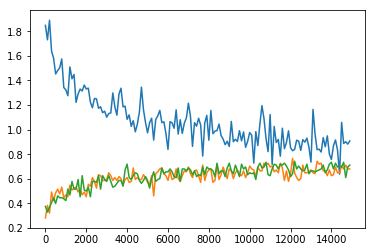

In [61]:
lals = np.array(lals) #ziel.-trening. pomar.-test. nieb.-entr
plt.plot(lals[:,0],lals[:,1])

plt.plot(lals[:,0],lals[:,3])
plt.plot(lals[:,0],lals[:,2])

In [47]:
opt = tf.train.AdadeltaOptimizer(learning_rate=0.01)
train_op = opt.minimize(loss)

In [48]:
global_step=0

In [49]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

In [50]:

lgvals = []


for i in range(global_step,global_step+15000):
    l, _ = sess.run([loss,train_op])
    if i%10==0:   
        clear_output(wait=True)
        print(l,i+1)
    if i%100==0:
        Images,Labels = sess.run([test_images,test_sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r_test = np.sum(predicted==Labels)/Labels.size
        
        Images,Labels = sess.run([images,sparse_labels])
        predicted = np.argmax(sess.run(logits,feed_dict={images: Images}),axis=1)
        r = np.sum(predicted==Labels)/Labels.size
        lgvals.append([i,l,r,r_test])

global_step = i+1

1.8344 14991


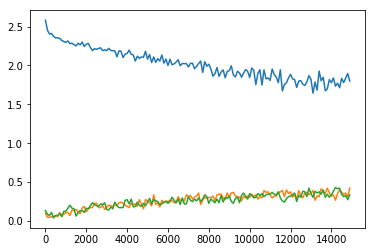

In [51]:
lgvals = np.array(lgvals) #ziel.-trening. pomar.-test. nieb.-entr
plt.plot(lgvals[:,0],lgvals[:,1])

plt.plot(lgvals[:,0],lgvals[:,3])
plt.plot(lgvals[:,0],lgvals[:,2])

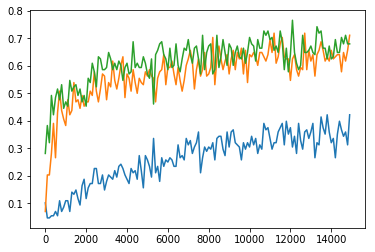

In [62]:
lgvals=np.array(lgvals)
plt.plot(lgvals[:,0],lgvals[:,3])
plt.plot(lvals[:,0],lvals[:,3])
plt.plot(lals[:,0],lals[:,3])

 Najlepsza dokładność na zbiorze testowym i treningowym była uzyskana poprzez Adagradoptimizer.